# Problem on CART-RF-ANN:

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

## Data Dictionary:

1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration)
7. Destination of the tour (Destination)
8. Amount of sales of tour insurance policies (Sales)
9. The commission received for tour insurance firm (Commission)
10. Age of insured (Age)

In [82]:
# Import liabraries

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
sns.set()

## (Question 1) 
## Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.

In [83]:
# load the dataset
df = pd.read_csv('insurance_part2_data.csv')

In [84]:
# top 5 rows
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


### EDA (Exploratory Data Analysis)

In [85]:
# shape of the dataset
df.shape
print(' The number of columns (variables) in the dataset is',df.shape[1],'\n'
,'The number of rows (observations per variable) in the dataset is',df.shape[0])

 The number of columns (variables) in the dataset is 10 
 The number of rows (observations per variable) in the dataset is 3000


In [86]:
# information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
Age             3000 non-null int64
Agency_Code     3000 non-null object
Type            3000 non-null object
Claimed         3000 non-null object
Commision       3000 non-null float64
Channel         3000 non-null object
Duration        3000 non-null int64
Sales           3000 non-null float64
Product Name    3000 non-null object
Destination     3000 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [87]:
## check is there any null data in the dataset
df.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [88]:
## check duplicates in the dataset
df_duplicate = df.duplicated()
print('There are',df_duplicate.sum(), 'records in the dataset which are duplicates')

There are 139 records in the dataset which are duplicates


#### Let's not remove these duplicates as there might be posibilities that they are different customers as we dont have any unique identifier.

In [89]:
# creating copy of the dataset
df_new = df

In [90]:
df_new.shape

(3000, 10)

In [91]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
Age             3000 non-null int64
Agency_Code     3000 non-null object
Type            3000 non-null object
Claimed         3000 non-null object
Commision       3000 non-null float64
Channel         3000 non-null object
Duration        3000 non-null int64
Sales           3000 non-null float64
Product Name    3000 non-null object
Destination     3000 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


__Insight1:__
- There are __10 variables__ in the dataset with __3000 records__
- There is __ZERO__ null values in the dataset
- There are __139 recrods__ in the dataset are __potential duplicates__. Let's not remove these observations as there might be __posibilities that they are different customers__ as we dont have any __unique identifier__
- __Four__ variables are numerical (i.e. Age, Commision, Duration, Sales)
- __Six__ variables are categorical (i.e. Agency_Code, Type, Claimed, Channel, Product Name, Destination)
- We have _target(dependent) variable_ as __"Claimed"__

In [92]:
# descriptive statistics summary
df_new.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,3000,NaN,NaN,NaN,38.091,10.4635,8,32,36,42,84
Agency_Code,3000,4,EPX,1365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,3000,2,Travel Agency,1837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Claimed,3000,2,No,2076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Commision,3000,NaN,NaN,NaN,14.5292,25.4815,0,0,4.63,17.235,210.21
Channel,3000,2,Online,2954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,3000,NaN,NaN,NaN,70.0013,134.053,-1,11,26.5,63,4580
Sales,3000,NaN,NaN,NaN,60.2499,70.734,0,20,33,69,539
Product Name,3000,5,Customised Plan,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,3000,3,ASIA,2465,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Insight2:__ By looking at the dataset, looks like there are outliers in the variables. Further,


_Numercial Variables:_

- There is a __significant gap between mean and median for commision, duration and sales.__ 
- There is a __NEGATIVE__ duration value found as __"min value"__ and __"max value"__ as __"4580"__ which means data requires cleansing before we proceed for modeling.


_Categorical Variables:_

- _Product Name_ has the _5_ unique values followed by _Agency code with 4,Destination with 3_ and _Type and Channel with 2_ unique values respectively.

### Univariate Analysis (Numerical Variables)

Text(0.5, 1.0, 'Sales boxplot')

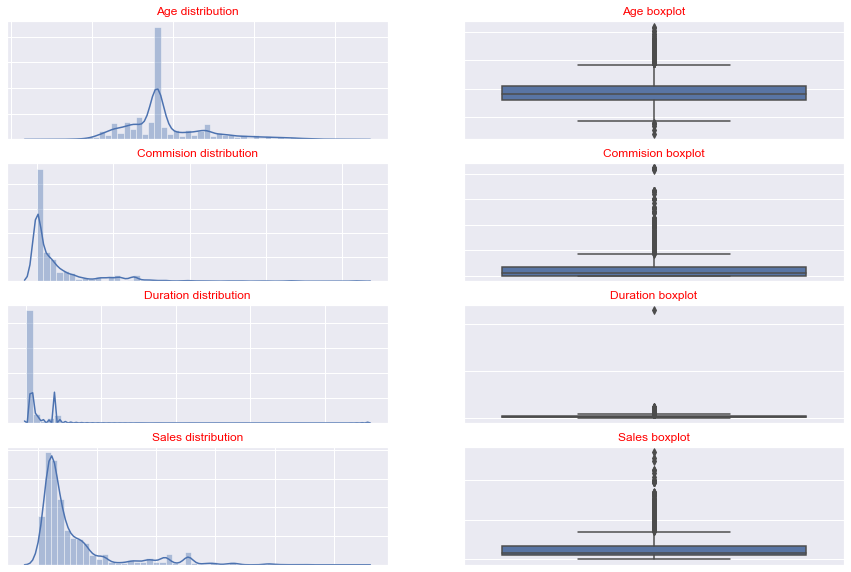

In [93]:
# histogram & boxplot for 4 numerical variables

fig,axes =  plt.subplots(4,2)
fig.set_size_inches(15,10)

x1 = df_new['Age']

a = sns.distplot(x1, ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Age distribution',fontsize = 12, color = 'red')

a = sns.boxplot(x1, ax = axes[0][1],orient = 'v')
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Age boxplot',fontsize = 12,color = 'red')

x2 = df_new['Commision']

a = sns.distplot(x2, ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Commision distribution',fontsize = 12, color = 'red')

a = sns.boxplot(x2, ax = axes[1][1],orient = 'v')
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Commision boxplot',fontsize = 12,color = 'red')

x3 = df_new['Duration']

a = sns.distplot(x3, ax = axes[2][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Duration distribution',fontsize = 12, color = 'red')

a = sns.boxplot(x3, ax = axes[2][1],orient = 'v')
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Duration boxplot',fontsize = 12,color = 'red')

x4 = df_new['Sales']

a = sns.distplot(x4, ax = axes[3][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Sales distribution',fontsize = 12, color = 'red')

a = sns.boxplot(x4, ax = axes[3][1],orient = 'v')
a.set(xlabel=None)
a.set(ylabel=None)
a.set(xticklabels=[])
a.set(yticklabels=[])
a.set_title('Sales boxplot',fontsize = 12,color = 'red')

In [94]:
df_new.skew() #it gives the details around skewness in the dataset.

Age           1.149713
Commision     3.148858
Duration     13.784681
Sales         2.381148
dtype: float64

__Insight3:__ 

In Univariate analysis(numerical variables), we have used __distribution plot and box plot__ and found:

- For __Commision, Duration & Sales variables are not normally distributed__ where __Age variable has similar to normal distribution trend__
- All __four variables__ have __outliers__ in the dataset.

### Univariate Analysis (Categorical Variables)

Text(0.5, 1.0, 'Destination countplot')

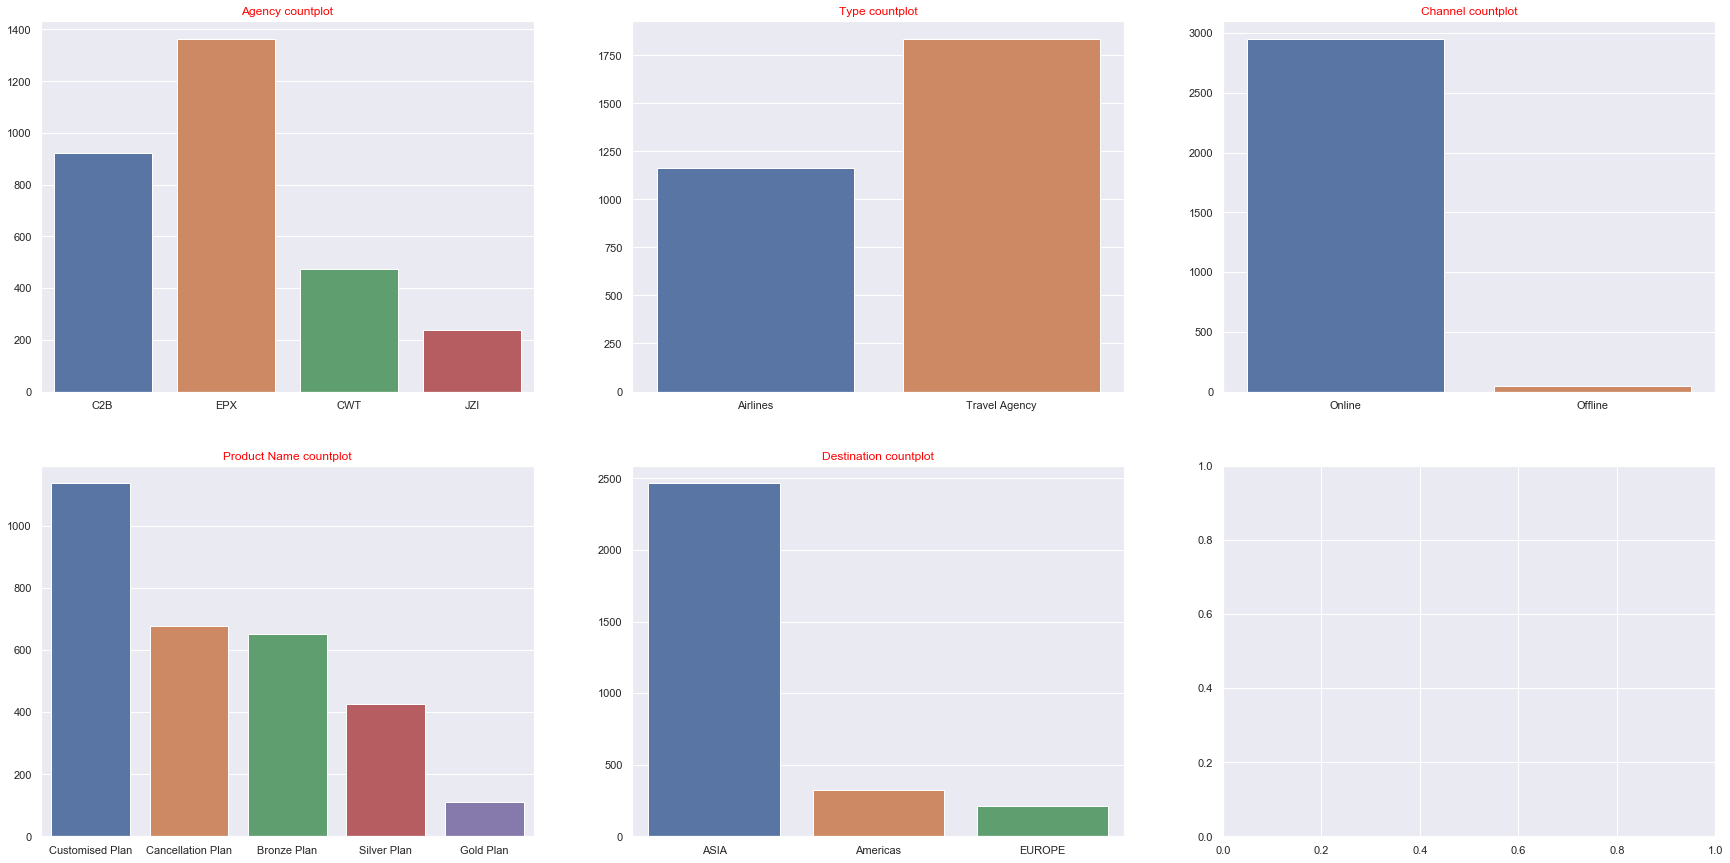

In [95]:
# countplot for 5 categorical variables

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

x1 = df_new['Agency_Code']

a = sns.countplot(x1, ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency countplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.countplot(x2, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type countplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.countplot(x3, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel countplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.countplot(x4,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product Name countplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.countplot(x5, ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination countplot',fontsize = 12, color = 'red')

__Insight4:__ 

In Univariate analysis(categorial variables), we have used __count plot__ and found:

- __EPX Agency__ has the highest count followed by C2B, CWT and JZI.
- __Travel Agency__ type of insurance firm has the highest count followed by __airlines__
- __Online__ is the distribution channel has the more contribution followed by __offline__
- __Customised Plan__ seems the in demand plan followed by Cancellation plan, Bronze plan, Silver plan & Gold plan
- __Asia__ is the destination which has more contribution followed by Americas & Europe

### Bivariate Analysis (Numerical variables vs Numerical variables)

For Numeric vs Numeric Scatter plot and heat map are the options to go with

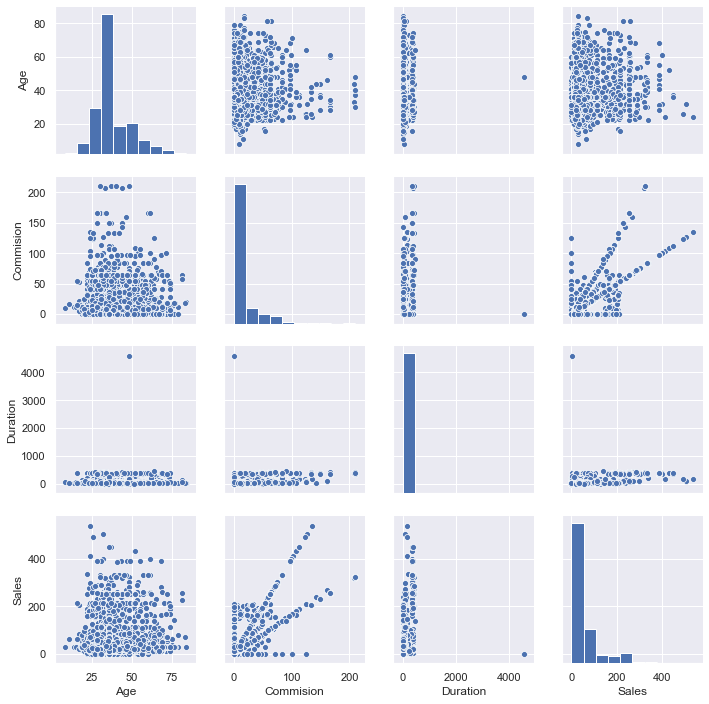

In [96]:
# scatter plot
sns.pairplot(df_new)

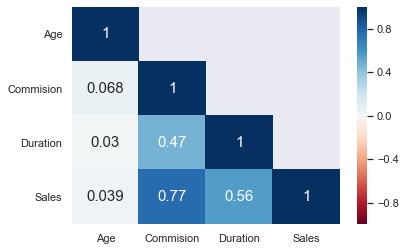

In [97]:
# Heatmap view
sns.heatmap(df[['Age', 'Commision', 
    'Duration', 'Sales']].corr(),annot=True,annot_kws={"size": 15},vmax=1,vmin=-1,cmap='RdBu',
            mask=np.triu(df[['Age', 'Commision','Duration', 'Sales']].corr(),+1))

__Insight5:__ 

In Bivariate analysis(Numerical variables), we have used __scatter plot & heatmap__ and found:

- In scatter plot and heat map both stats that __Sales & Commision__ variables have the quite a good correlation __(0.77)__ _(i.e. if commision increases sales increases)_
- Other variables are not showing that strong relationship.

### Bivariate Analysis (Categorical variables vs Numerical variables)

For Categorical vs Numerical Violin plot & Box plot are the right option to go with

Text(0.5, 1.0, 'Destination to sales violinplot')

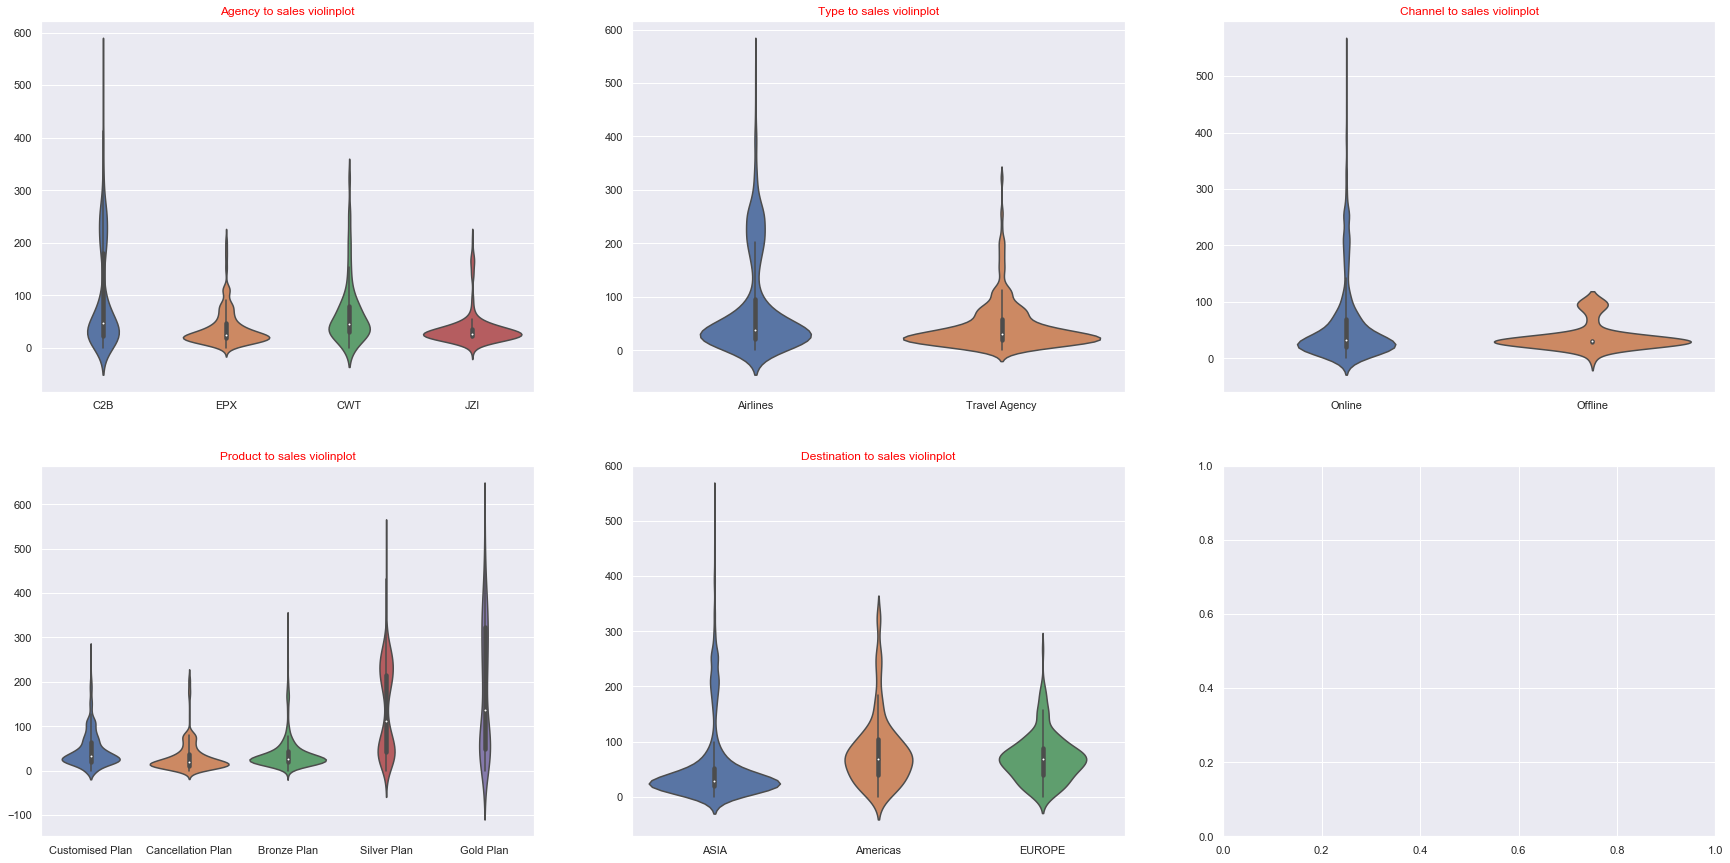

In [98]:
# violin plot for all categorical & numercial variables as "Sales"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new['Sales']
x1 = df_new['Agency_Code']

a = sns.violinplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to sales violinplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.violinplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to sales violinplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.violinplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to sales violinplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.violinplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to sales violinplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.violinplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to sales violinplot',fontsize = 12, color = 'red')

Text(0.5, 1.0, 'Destination to sales boxplot')

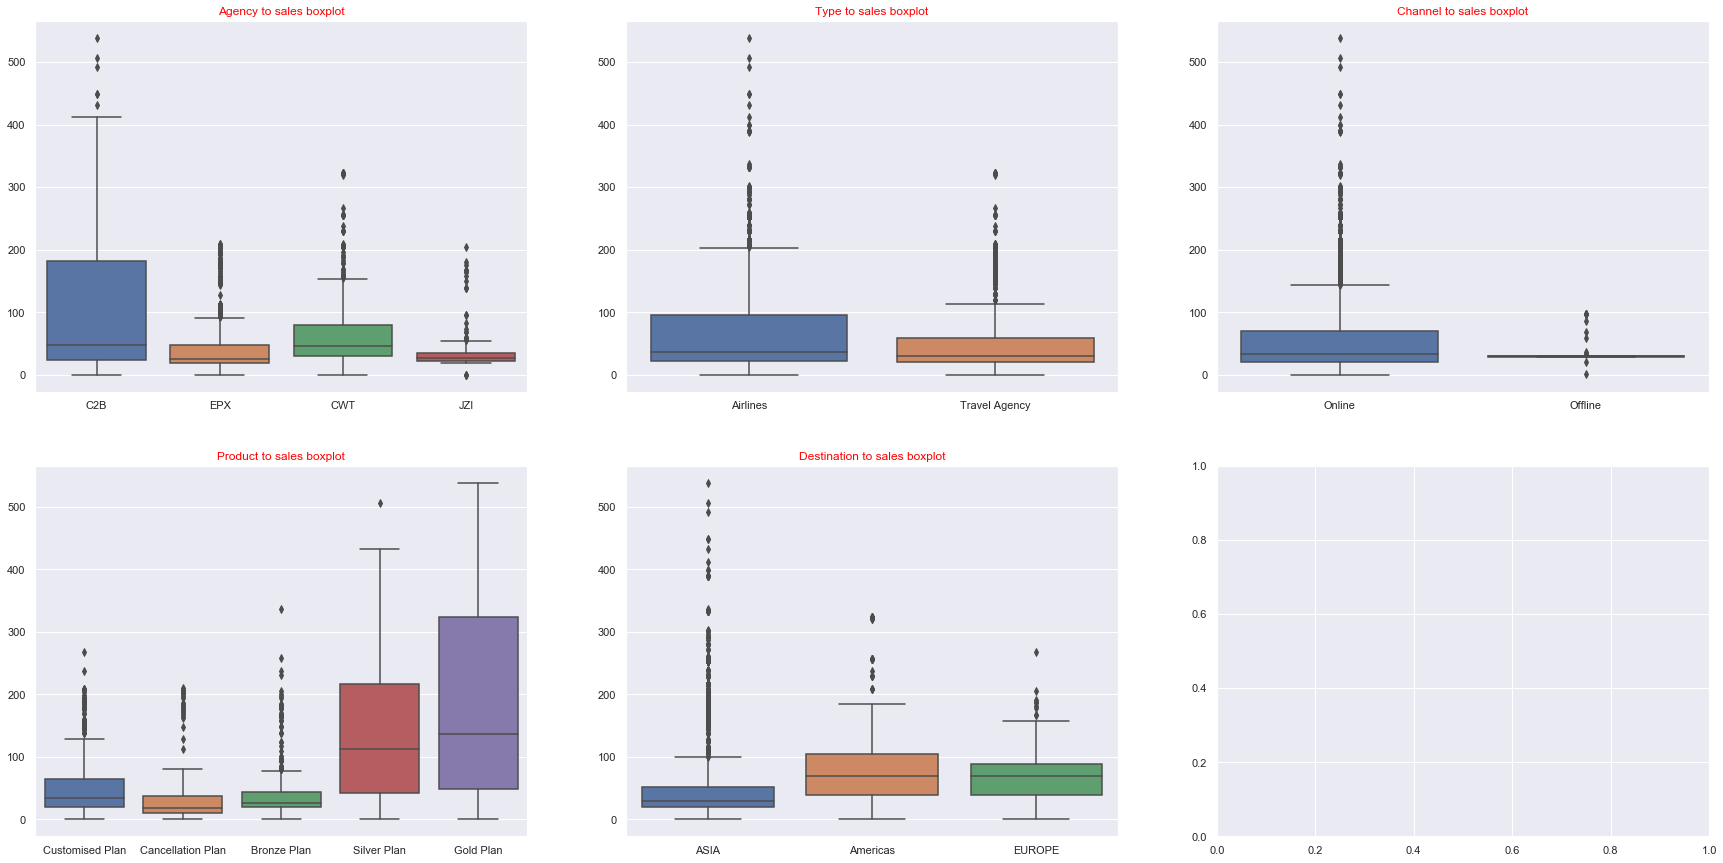

In [99]:
# box plot for all categorical & numercial variables as "Sales"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new['Sales']
x1 = df_new['Agency_Code']

a = sns.boxplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to sales boxplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.boxplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to sales boxplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.boxplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to sales boxplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.boxplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to sales boxplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.boxplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to sales boxplot',fontsize = 12, color = 'red')

In [100]:
df_new.groupby(['Destination'])['Sales'].sum()

Destination
ASIA        139192.42
Americas     26423.45
EUROPE       15133.87
Name: Sales, dtype: float64

__Insight6:__ 

In Bivariate analysis(Categorical vs Numerical variables), we have compared __all categorical variables with sales__ and found:

- __Median sales across agencies__ are __not same__. Further, _C2B is the agency which has highest sales amongst others._
- __Airlines__ type of insurance firm has the __highest sales__ but _median of both are almost similar._
- __Online__ distribtion channel is the __quite preferred one__. _hence, sales around the same it quite higher than offline_
- __Gold & Silver plan__ are the __key contributors to the sales.__
- __Asia__ is the destination from __where sales are coming from__. _but Asia has good amount of outliers and median of the same is quite lower then other destionations._

Text(0.5, 1.0, 'Destination to commision violinplot')

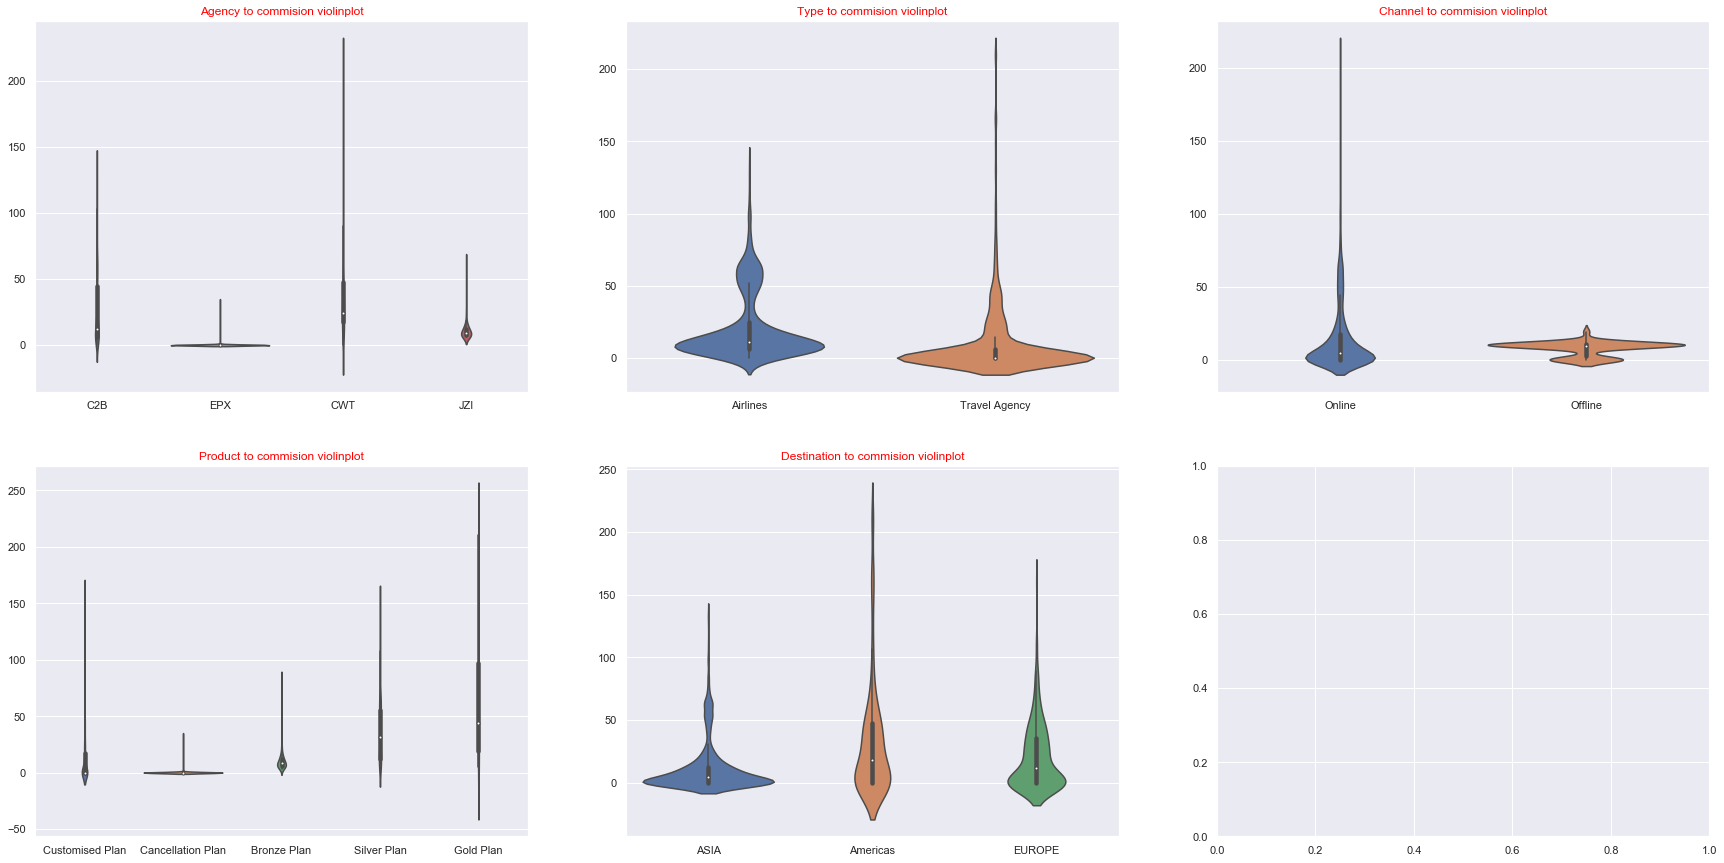

In [101]:
# violin plot for all categorical & numercial variables as "Commision"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new['Commision']
x1 = df_new['Agency_Code']

a = sns.violinplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to commision violinplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.violinplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to commision violinplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.violinplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to commision violinplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.violinplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to commision violinplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.violinplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to commision violinplot',fontsize = 12, color = 'red')

Text(0.5, 1.0, 'Destination to commision boxplot')

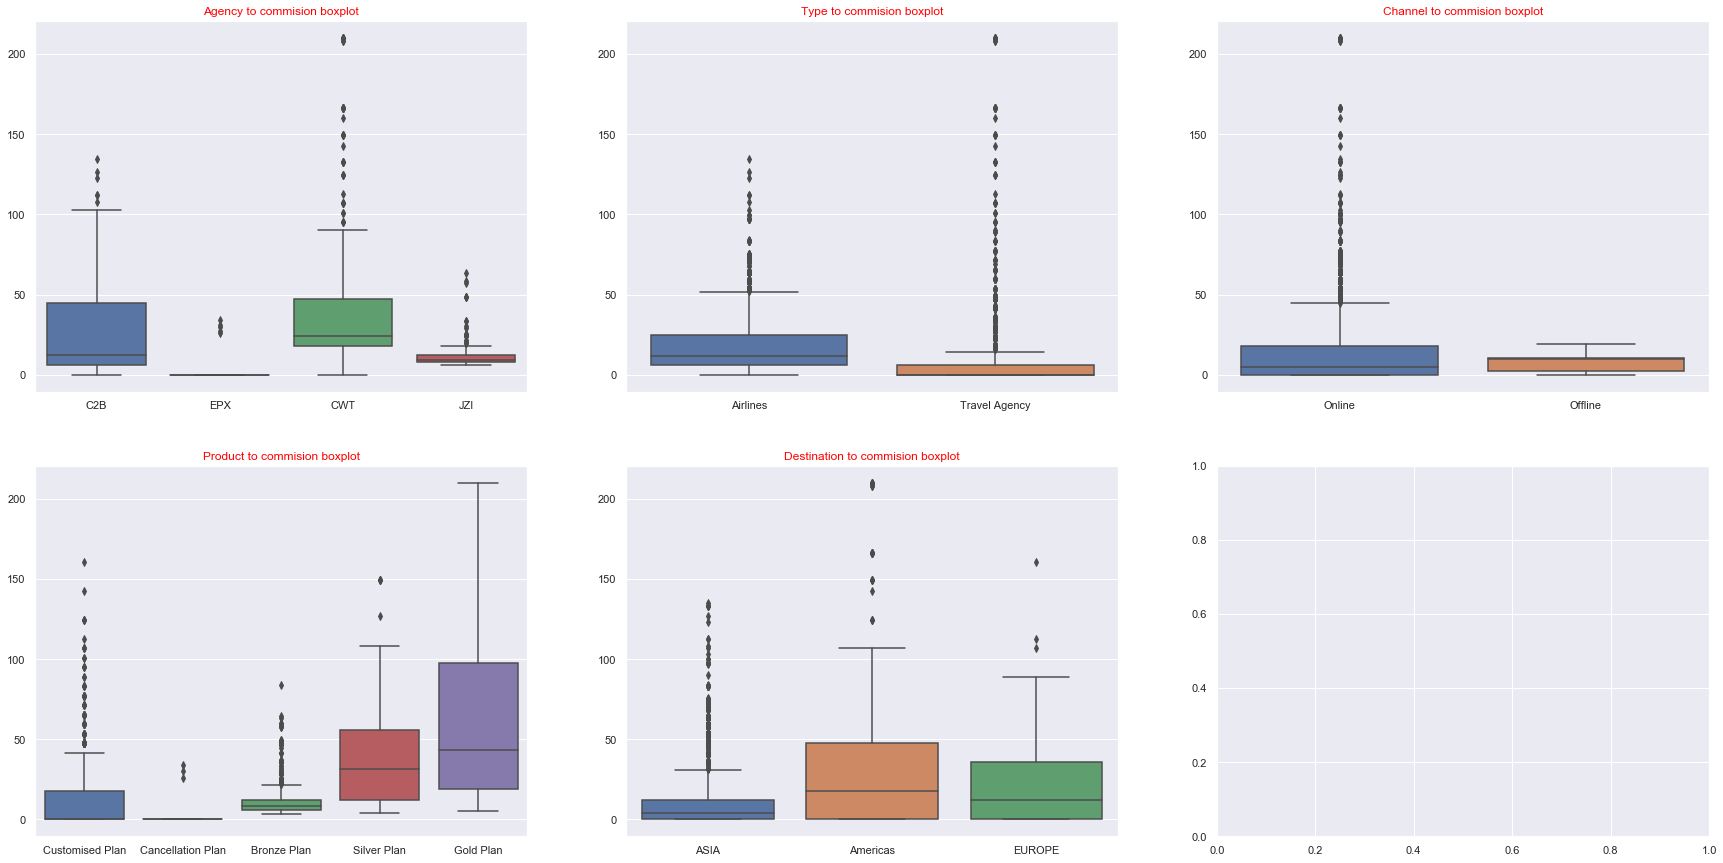

In [102]:
# box plot for all categorical & numercial variables as "Commision"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new['Commision']
x1 = df_new['Agency_Code']

a = sns.boxplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to commision boxplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.boxplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to commision boxplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.boxplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to commision boxplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.boxplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to commision boxplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.boxplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to commision boxplot',fontsize = 12, color = 'red')

In [103]:
df_new.groupby(['Destination'])['Commision'].sum()

Destination
ASIA        28919.89
Americas    10348.77
EUROPE       4318.95
Name: Commision, dtype: float64

__Insight7:__ 

In Bivariate analysis(Categorical vs Numerical variables), we have compared __all categorical variables with commision__ and found:

- __Median commision across agencies__ are __not same__. Further, _CWT and C2B are the agencies have highest commisions amongst others._
- __Airlines__ type of insurance firm has the __highest commision__ 
- __Online__ distribtion channel is the __quite preferred one__. _hence, commision around the same it quite higher than offline_
- __Gold & Silver plan__ are the __key contributors.__
- __Asia__ is the destination from __where highest commisions is coming__.

Text(0.5, 1.0, 'Destination to duration violinplot')

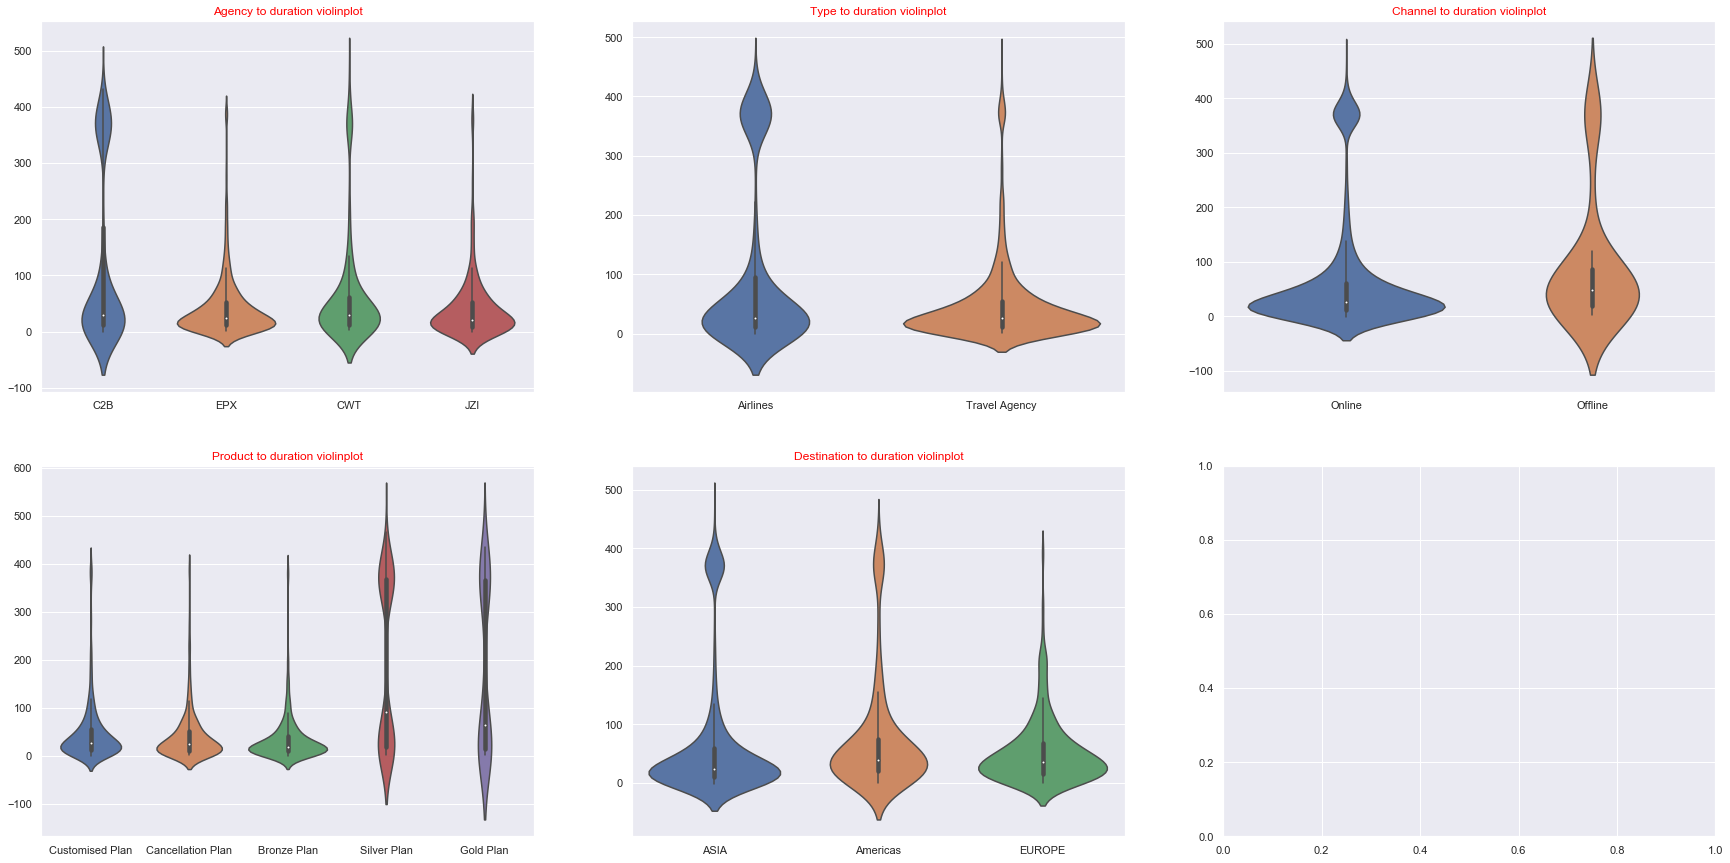

In [104]:
# violin plot for all categorical & numercial variables as "Duration"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new[df_new['Duration'] != 4580]["Duration"] #excluding the exeteme outlier which is 4580 days.
x1 = df_new['Agency_Code']

a = sns.violinplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to duration violinplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.violinplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to duration violinplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.violinplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to duration violinplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.violinplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to duration violinplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.violinplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to duration violinplot',fontsize = 12, color = 'red')

Text(0.5, 1.0, 'Destination to duration boxplot')

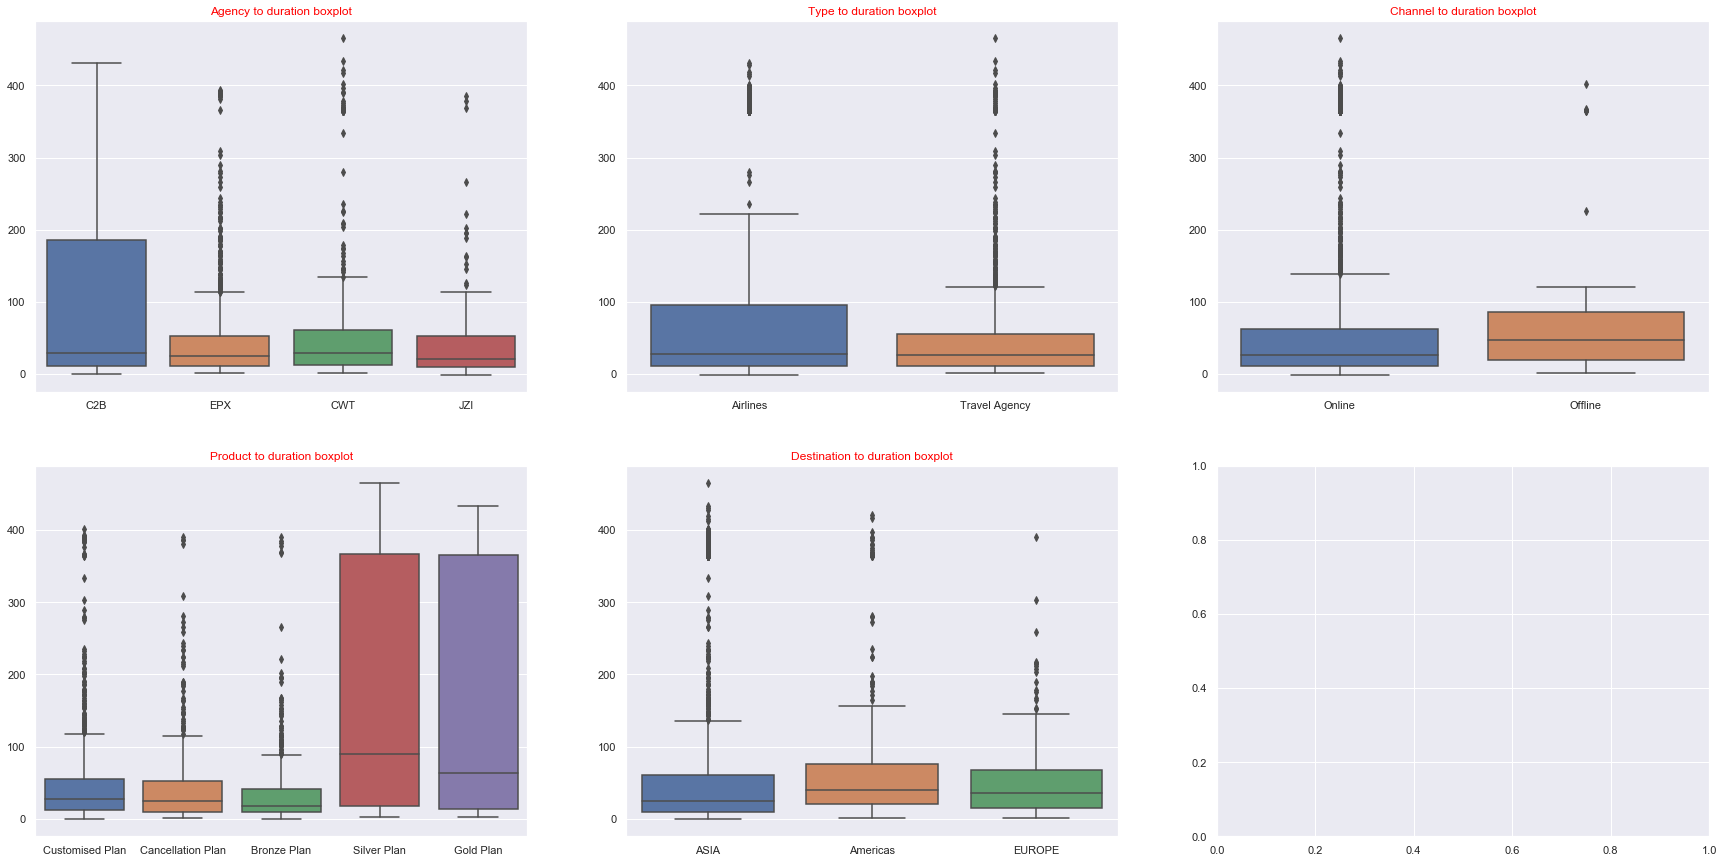

In [105]:
# box plot for all categorical & numercial variables as "Duration"

fig,axes =  plt.subplots(2,3)
fig.set_size_inches(30,15)

y = df_new[df_new['Duration'] != 4580]["Duration"] #excluding the exeteme outlier which is 4580 days.
x1 = df_new['Agency_Code']

a = sns.boxplot(x=x1, y=y,ax = axes[0][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Agency to duration boxplot',fontsize = 12, color = 'red')

x2 = df_new['Type']

a = sns.boxplot(x=x2, y=y, ax = axes[0][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Type to duration boxplot',fontsize = 12, color = 'red')

x3 = df_new['Channel']

a = sns.boxplot(x=x3, y=y, ax = axes[0][2])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Channel to duration boxplot',fontsize = 12, color = 'red')

x4 = df_new['Product Name']

a = sns.boxplot(x=x4, y=y,ax = axes[1][0])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Product to duration boxplot',fontsize = 12, color = 'red')

x5 = df_new['Destination']

a = sns.boxplot(x=x5, y=y,ax = axes[1][1])
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('Destination to duration boxplot',fontsize = 12, color = 'red')

In [106]:
df_new.groupby(['Destination'])['Duration'].median()

Destination
ASIA        24
Americas    40
EUROPE      36
Name: Duration, dtype: int64

__Insight8:__ 

In Bivariate analysis(Categorical vs Numerical variables), we have compared __all categorical variables with duration__ and found:

- There is __one record where duration is "4580" days__ which we are __excluding for this visualisation__.
- __Median duration across agencies__ are __almost same__. Further, _C2B is the agency where people chooses higher duration days insrances._
- __Median duration across insurance firm type__ are __almost same__. _It means there no such preferences of customer on duration days while choosing insurance firm type_
- __Online__ distribtion channel is the __quite preferred one__. _but we can see the median of online is lesser then offline_
- __Gold & Silver plan__ are the products people prefered while __going for higher duration days__
- There is __a slight change in destination medians__ in terms of duration days are concern between _Asia and (Americas & Europe)_.

### Target Variable Analysis ("Claimed")

In [107]:
df_new['Claimed'].value_counts()

No     2076
Yes     924
Name: Claimed, dtype: int64

In [108]:
counts = df_new['Claimed'].value_counts(normalize=True)
counts

No     0.692
Yes    0.308
Name: Claimed, dtype: float64

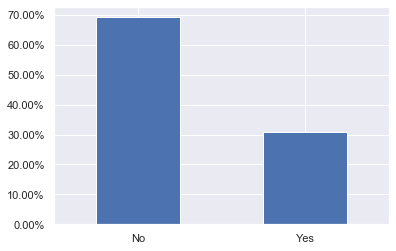

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts.plot(ax=ax,kind='bar', stacked=True, rot=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax.yaxis.grid(True)
ax.set_axisbelow(True)
plt.show()

__Insight9:__ 

- Out of total there are __2076(~69%) records__ have __no claimed status__. _it means only 924(~31%) records having claimed status as "yes"._

### Before we move to next question we need to convert all the object variables into categorical

In [110]:
for feature in df_new.columns: 
    if df_new[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df_new[feature].unique()))
        print(pd.Categorical(df_new[feature].unique()).codes)
        df_new[feature] = pd.Categorical(df_new[feature]).codes



feature: Agency_Code
[C2B, EPX, CWT, JZI]
Categories (4, object): [C2B, CWT, EPX, JZI]
[0 2 1 3]


feature: Type
[Airlines, Travel Agency]
Categories (2, object): [Airlines, Travel Agency]
[0 1]


feature: Claimed
[No, Yes]
Categories (2, object): [No, Yes]
[0 1]


feature: Channel
[Online, Offline]
Categories (2, object): [Offline, Online]
[1 0]


feature: Product Name
[Customised Plan, Cancellation Plan, Bronze Plan, Silver Plan, Gold Plan]
Categories (5, object): [Bronze Plan, Cancellation Plan, Customised Plan, Gold Plan, Silver Plan]
[2 1 0 4 3]


feature: Destination
[ASIA, Americas, EUROPE]
Categories (3, object): [ASIA, Americas, EUROPE]
[0 1 2]


In [111]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
Age             3000 non-null int64
Agency_Code     3000 non-null int8
Type            3000 non-null int8
Claimed         3000 non-null int8
Commision       3000 non-null float64
Channel         3000 non-null int8
Duration        3000 non-null int64
Sales           3000 non-null float64
Product Name    3000 non-null int8
Destination     3000 non-null int8
dtypes: float64(2), int64(2), int8(6)
memory usage: 111.5 KB


### --------------------------------------------------------------- Question 1 Ends ---------------------------------------------------------------------

## (Question 2) 
## Data Split: Split the data into test(30% of the data) and train(70% of the data), build classification model CART, Random Forest, Artificial Neural Network

#### Define dependent and independent variables 

In [112]:
# identify dependent variables and independent variables and put it into Y and X dataset respectively.

X = df_new.drop('Claimed', axis =1)

Y = df_new.pop('Claimed')

In [113]:
X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0.00,1,34,20.00,2,0
2,39,1,1,5.94,1,3,9.90,2,1
3,36,2,1,0.00,1,4,26.00,1,0
4,33,3,0,6.30,1,53,18.00,0,0


In [114]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: Claimed, dtype: int8

#### Data Scaling

__Note:__ We already know that __Decision Tree and Random Forest__ takes care of the outliers but __ANN not__. Which means scaling is only required in ANN. In this assignment, we are using same dataset for all three models. hence, we are scaling the dataset and using them in all three models.

In [115]:
from scipy.stats import zscore
X_scaled=X.apply(zscore)
X_scaled.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,0.947162,-1.314358,-1.256796,-0.542807,0.124788,-0.470051,-0.816433,0.268835,-0.434646
1,-0.199870,0.697928,0.795674,-0.570282,0.124788,-0.268605,-0.569127,0.268835,-0.434646
2,0.086888,-0.308215,0.795674,-0.337133,0.124788,-0.499894,-0.711940,0.268835,1.303937
3,-0.199870,0.697928,0.795674,-0.570282,0.124788,-0.492433,-0.484288,-0.525751,-0.434646
4,-0.486629,1.704071,-1.256796,-0.323003,0.124788,-0.126846,-0.597407,-1.320338,-0.434646


#### Splitting data into training and test set (test_size=.30, random_state=1)¶

In [116]:
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y,test_size=.30,random_state=1)

In [117]:
# Checking the dimensions of the training and test data

print('X_train:',X_train.shape)
print('Y_train:',Y_train.shape)
print('X_test:',X_test.shape)
print('Y_test:',Y_test.shape)
print('Total Count:',df_new.shape[0])

X_train: (2100, 9)
Y_train: (2100,)
X_test: (900, 9)
Y_test: (900,)
Total Count: 3000


### -------------------------------------------         Model Building Decision Tree (CART)         -------------------------------------------

In [118]:
dt_model = DecisionTreeClassifier(criterion = 'gini',random_state=1)
dt_model.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [119]:
train_char_label = ['No', 'Yes']
df_tree = open('df_tree.dot','w')
df_dot_data = tree.export_graphviz(dt_model, 
                                out_file=df_tree, 
                                feature_names = list(X_train), 
                                class_names = list(train_char_label))

df_tree.close()

In [120]:
# open browser and type
# www.webgraphviz.com 
# paste the df_tree codes (which will be in the word file) and generate the graph!!

By seeing the visualisation using df_tree in wizgraph it is difficult to inference about the tree but mentioned below are the key observations:

- Max depth of the tree is __~25__
- Many of the leaf samples have their sample size as __"1"__
- Most of the samples split have their split after depth 6 is __between 2 to 10__

In [121]:
# Step: Now we will check the accuracy of our model on training and test data:

dt_model.score(X_train, Y_train)

0.9947619047619047

In [122]:
dt_model.score(X_test, Y_test)

# 2-3%  difference in accuracy is ok. Beyond that is not generally accepted. 
# And this extra difference is called "Overfitting" and is a classic problem of Decision Trees.

0.7177777777777777

### Let's try to find the best model combinations using GridSearch CV

#### param_grid_dtcl (iteration 1)

In [123]:
param_grid_dtcl = {
    'criterion': ['gini'],
    'max_depth': [5,10,20],
    'min_samples_leaf': [60,120,180], 
    'min_samples_split': [200,300,400,500]
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search_dtcl = GridSearchCV(estimator = dtcl, param_grid = param_grid_dtcl, cv = 10)

In [124]:
grid_search_dtcl.fit(X_train, Y_train)
print(grid_search_dtcl.best_params_)
best_grid_dtcl1 = grid_search_dtcl.best_estimator_
best_grid_dtcl1

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 60, 'min_samples_split': 200}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=60, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

__Inferences from iteration 1:__
 
  i) max_depth: best number is 5 hence, lets try to go to little left side. 
  
 ii) min_samples_leaf: best number is 60 so lets keep go little left again.
 
iii) min_samples_split: as its showing 200 so lets keep go little left again.

In [125]:
# step: Now we will re-check the accuracy of our model on training and test data (as done earlier):
best_grid_dtcl1.score(X_train, Y_train)

0.7871428571428571

In [126]:
best_grid_dtcl1.score(X_test, Y_test)

0.7711111111111111

#### param_grid_dtcl (iteration 2)

In [127]:
param_grid_dtcl = {
    'criterion': ['gini'],
    'max_depth': [3,4,5,6],
    'min_samples_leaf': [40,50,60,70], 
    'min_samples_split': [100,200,300]
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search_dtcl = GridSearchCV(estimator = dtcl, param_grid = param_grid_dtcl, cv = 10)

In [128]:
grid_search_dtcl.fit(X_train, Y_train)
print(grid_search_dtcl.best_params_)
best_grid_dtcl = grid_search_dtcl.best_estimator_
best_grid_dtcl

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 60, 'min_samples_split': 200}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=60, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

__Inferences from iteration 2:__
 
Now, max_depth, min_samples_leaf and min_samples_split are looks like well frozen. so, let's consider this as the best parameter for the __Decision tree model__.

Best Parameter for the model : __{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 60, 'min_samples_split': 200}__

In [129]:
# step: Now we will re-check the accuracy of our model on training and test data (as done earlier):
best_grid_dtcl.score(X_train, Y_train)

0.7871428571428571

In [130]:
best_grid_dtcl.score(X_test, Y_test)

0.7711111111111111

Using above best parameter __(i.e. {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 60, 'min_samples_split': 200})__.
We have got __training score (78.7%)__ and __testing score (77.1%)__ which is inline.

#### Let's visualise the DT using www.webgraphviz.com 

In [131]:
train_char_label = ['No', 'Yes']
reg_tree = open('reg_tree.dot','w')
reg_dot_data = tree.export_graphviz(best_grid_dtcl, 
                                out_file=reg_tree, 
                                feature_names = list(X_train), 
                                class_names = list(train_char_label))

reg_tree.close()

In [132]:
# open browser and type
# www.webgraphviz.com 
# paste the reg_tree codes (which will be in the word file) and generate the graph!!

#### DT visualisation image

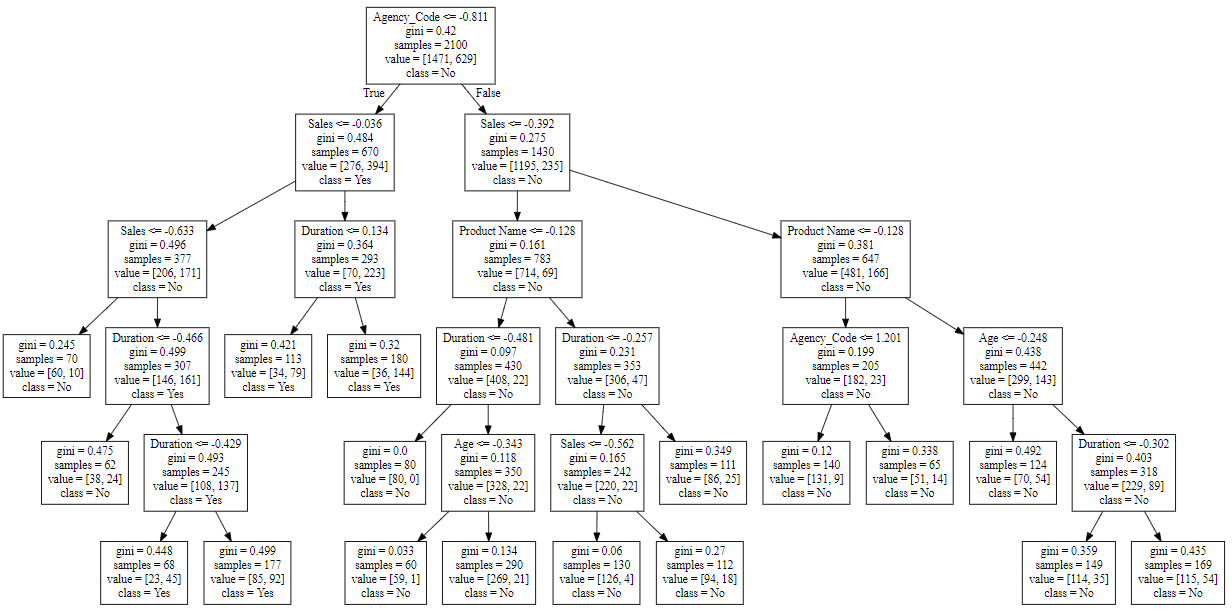

#### Feature Importance (DT): Training Data

In [133]:
print (pd.DataFrame(best_grid_dtcl.feature_importances_, columns = ["Importance"], 
                    index = X_train.columns).sort_values('Importance',ascending=False))

              Importance
Agency_Code     0.622966
Sales           0.262609
Product Name    0.056775
Duration        0.040261
Age             0.017389
Type            0.000000
Commision       0.000000
Channel         0.000000
Destination     0.000000


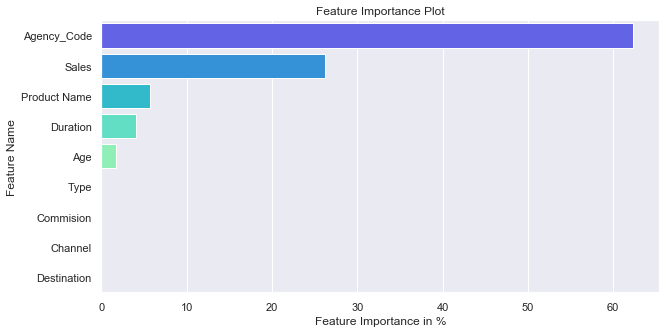

In [134]:
x = pd.DataFrame(best_grid_dtcl.feature_importances_*100,index = X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x[0],x.index,palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

#### Predicting on Training and Test dataset

In [135]:
Y_train_predict_dt = best_grid_dtcl.predict(X_train)
Y_test_predict_dt = best_grid_dtcl.predict(X_test)

In [136]:
Y_train_predict_dt.shape

(2100,)

In [137]:
Y_test_predict_dt.shape

(900,)

#### Getting the Predicted Classes

In [138]:
Y_train_predict_dt

array([0, 0, 1, ..., 0, 0, 1], dtype=int8)

In [139]:
Y_test_predict_dt

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

#### Getting the Predicted Probabilities

In [140]:
Y_train_predict_dt_prob = best_grid_dtcl.predict_proba(X_train)
Y_test_predict_dt_prob = best_grid_dtcl.predict_proba(X_test)

In [141]:
pd.DataFrame(Y_train_predict_dt_prob).head(2)

,0,1
0,0.969231,0.030769
1,0.680473,0.319527


In [142]:
pd.DataFrame(Y_test_predict_dt_prob).head(2)

,0,1
0,0.935714,0.064286
1,0.480226,0.519774


### -------------------------------------------         Model Building Decistion Tree (CART) ENDS      -------------------------------------------

### -------------------------------------------         Model Building Random Forest (RF)      -------------------------------------------

In [143]:
#We will now define Random Forest model:
rfcl = RandomForestClassifier(criterion='gini', 
                              random_state=1, 
                              oob_score=True, 
                              max_features=4, 
                              n_estimators=501, 
                              max_depth = 10)

In [144]:
rfcl.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=501,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [145]:
#Let us check the Out Of Bag score
rfcl_oob_score = (rfcl.oob_score_)*100
rfcl_oob_score

78.28571428571428

In [146]:
#Let us check the Out Of Bag error rate
rfcl_oob_score_error = (1-rfcl.oob_score_)*100
rfcl_oob_score_error

21.71428571428572

In [147]:
# Now we will check the accuracy of our model on training data:
rfcl.score(X_train,Y_train)

0.8947619047619048

In [148]:
# Now we will check the accuracy of our model on test data:
rfcl.score(X_test,Y_test)

0.7711111111111111

We see that the accuracy on the __Training data is 0.89__ and the accuracy on the __test data is 0.77__. This shows __~12% of gap between train and test data__ which is a __case of overfitting__. We have allowed the Decision Trees inside the Random Forest algorithm to grow to their fullest. We need to regularize this particular Random Forest model to achieve comparative accuracy on both the Training and Test data.

We regularized the Decision Tree by looking at a largely overgrown tree. Here, in the case of Random Forest it is not possible to look at every tree and then go ahead and prune the trees. To make this job simpler we are going to use __a command called GridSearchCV.__

#### param_grid_rfcl (iteration 1)

In [149]:
param_grid_rfcl = {
    'max_depth': [3,4,5,6,7],
    'max_features': [2,3,4,5,6],
    'min_samples_leaf': [50, 100],
    'min_samples_split': [150, 300],
    'n_estimators': [301, 501]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search_rfcl = GridSearchCV(estimator = rfcl, param_grid = param_grid_rfcl, cv = 10)

In [150]:
grid_search_rfcl.fit(X_train, Y_train)
print(grid_search_rfcl.best_params_)
best_grid_rfcl1 = grid_search_rfcl.best_estimator_
best_grid_rfcl1

{'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 50, 'min_samples_split': 150, 'n_estimators': 501}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=150,
                       min_weight_fraction_leaf=0.0, n_estimators=501,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

__Inferences from iteration 1:__
 
  i) max_depth: best number is 6 hence, lets squeeze the list to 5 to 7 
  
 ii) max_features: currently its showing as 2 but lets not change the list now.
  
iii) min_samples_leaf: best number is 50 so lets keep go little left again and include 10 and 30.
 
 iv) min_samples_split: best number is 150 so lets keep go little left again.

  v) n_estimators: let's not change the trees list.

In [151]:
# Now we will check the accuracy of our model on training data:
best_grid_rfcl1.score(X_train,Y_train)

0.7876190476190477

In [152]:
# Now we will check the accuracy of our model on test data:
best_grid_rfcl1.score(X_test,Y_test)

0.7533333333333333

#### param_grid_rfcl (iteration 2)

In [153]:
param_grid_rfcl = {
    'max_depth': [5,6,7],
    'max_features': [2,3,4,5,6],
    'min_samples_leaf': [10,30,50],
    'min_samples_split': [50,100,150],
    'n_estimators': [301, 501]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search_rfcl = GridSearchCV(estimator = rfcl, param_grid = param_grid_rfcl, cv = 10)

In [154]:
grid_search_rfcl.fit(X_train, Y_train)
print(grid_search_rfcl.best_params_)
best_grid_rfcl2 = grid_search_rfcl.best_estimator_
best_grid_rfcl2

{'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 501}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=501,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

__Inferences from iteration 2:__
 
  i) max_depth: best number is still 6. so let's consider the list to 5 to 7.
  
 ii) max_features: currently its showing as 6 which has moved from 2. so, lets squeeze the list to 3 to 6.
  
iii) min_samples_leaf: best number is 10 so lets keep go little left again and squeeze the list to 7 to 10.
 
 iv) min_samples_split: best number is 50 so lets keep go little left again and squeeze the list to 40 to 50.

  v) n_estimators: let's not change the trees list.

In [155]:
# Now we will check the accuracy of our model on training data:
best_grid_rfcl2.score(X_train,Y_train)

0.81

In [156]:
# Now we will check the accuracy of our model on test data:
best_grid_rfcl2.score(X_test,Y_test)

0.7711111111111111

#### param_grid_rfcl (iteration 3)

In [157]:
param_grid_rfcl = {
    'max_depth': [5,6,7],
    'max_features': [3,4,5,6],
    'min_samples_leaf': [7,8,9,10],
    'min_samples_split': [40,45,50],
    'n_estimators': [301, 501]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search_rfcl = GridSearchCV(estimator = rfcl, param_grid = param_grid_rfcl, cv = 10)

In [158]:
grid_search_rfcl.fit(X_train, Y_train)
print(grid_search_rfcl.best_params_)
best_grid_rfcl = grid_search_rfcl.best_estimator_
best_grid_rfcl

{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 40, 'n_estimators': 301}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, n_estimators=301,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [159]:
# Now we will check the accuracy of our model on training and test data:
best_grid_rfcl.score(X_train,Y_train)

0.8157142857142857

In [160]:
best_grid_rfcl.score(X_test,Y_test)

0.7755555555555556

__Inferences from iteration 3:__
 
Now, max_depth, max_features, min_samples_leaf, min_samples_split and n_estimators are looks like well frozen. so, let's consider this as the best parameter for the __Random Forest model__.

Best Parameter for the model : __{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 40, 'n_estimators': 301}__

#### Feature Importance (RF): Training Data

In [161]:
print (pd.DataFrame(best_grid_rfcl.feature_importances_, columns = ["Importance"], 
                    index = X_train.columns).sort_values('Importance',ascending=False))

              Importance
Agency_Code     0.349620
Product Name    0.194576
Sales           0.170558
Commision       0.111002
Duration        0.074119
Age             0.054613
Type            0.037946
Destination     0.006161
Channel         0.001405


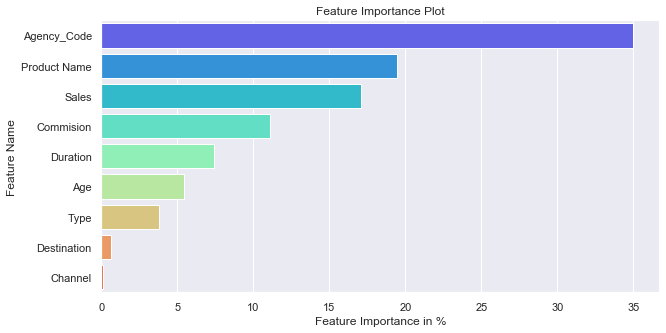

In [162]:
x = pd.DataFrame(best_grid_rfcl.feature_importances_*100,index = X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x[0],x.index,palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

#### Predicting on Training and Test dataset

In [163]:
Y_train_predict_rf = best_grid_rfcl.predict(X_train)
Y_test_predict_rf = best_grid_rfcl.predict(X_test)

In [164]:
Y_train_predict_rf.shape

(2100,)

In [165]:
Y_test_predict_rf.shape

(900,)

#### Getting the Predicted Classes

In [166]:
Y_train_predict_rf

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [167]:
Y_test_predict_rf

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

#### Getting the Predicted Probabilities

In [168]:
Y_train_predict_rf_prob = best_grid_rfcl.predict_proba(X_train)
Y_test_predict_rf_prob = best_grid_rfcl.predict_proba(X_test)

In [169]:
pd.DataFrame(Y_train_predict_rf_prob).head(2)

,0,1
0,0.884733,0.115267
1,0.733226,0.266774


In [170]:
pd.DataFrame(Y_test_predict_rf_prob).head(2)

,0,1
0,0.760362,0.239638
1,0.461013,0.538987


### -------------------------------------------         Model Building Random Forest (RF) ENDS      -------------------------------------------

### -------------------------------------------         Model Building Artificial Neural Network (ANN)      -------------------------------------------

In [171]:
#We will now build ANN Model on training data using MLPClassifier function
nncl = MLPClassifier(hidden_layer_sizes=100,
                     max_iter=500, 
                     solver='sgd', 
                     activation='relu', 
                     random_state=1, 
                     verbose=True, 
                     tol=0.001)

In [172]:
nncl.fit(X_train,Y_train)

Iteration 1, loss = 0.73122427
Iteration 2, loss = 0.70476447
Iteration 3, loss = 0.67436926
Iteration 4, loss = 0.64722570
Iteration 5, loss = 0.62401539
Iteration 6, loss = 0.60474880
Iteration 7, loss = 0.58885920
Iteration 8, loss = 0.57578935
Iteration 9, loss = 0.56466886
Iteration 10, loss = 0.55535768
Iteration 11, loss = 0.54748592
Iteration 12, loss = 0.54054985
Iteration 13, loss = 0.53473764
Iteration 14, loss = 0.52971935
Iteration 15, loss = 0.52517309
Iteration 16, loss = 0.52119671
Iteration 17, loss = 0.51764002
Iteration 18, loss = 0.51455527
Iteration 19, loss = 0.51179245
Iteration 20, loss = 0.50922933
Iteration 21, loss = 0.50706619
Iteration 22, loss = 0.50502087
Iteration 23, loss = 0.50320436
Iteration 24, loss = 0.50151302
Iteration 25, loss = 0.49996051
Iteration 26, loss = 0.49863449
Iteration 27, loss = 0.49732865
Iteration 28, loss = 0.49621048
Iteration 29, loss = 0.49505678
Iteration 30, loss = 0.49406615
Iteration 31, loss = 0.49317394
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [173]:
# Let's' now check the accuracy of the model on both the training data before we go ahead
nncl.score(X_train,Y_train)

0.7704761904761904

In [174]:
# Let's' now check the accuracy of the model on both the test data before we go ahead
nncl.score(X_test,Y_test)

0.7422222222222222

We see that the training and test data gives comparable results but the training data gives slightly better results than the test data.

Let us try to tweak the different parameters of the __MLPClassifier function by using the GridSearhCV function__. This particular function will give us the best model based on a combination of parameters specified by us

In [175]:
param_grid_nncl = {
    'hidden_layer_sizes': [50,100,(50,100,50),200,500],
    'activation': ['logistic','tanh','relu'],
    'max_iter': [2500,3000,3500],
    'solver' : ['adam', 'sgd'],
    'tol': [0.001, 0.0001]
}

nncl = MLPClassifier(random_state=1)

grid_search_nncl = GridSearchCV(estimator = nncl, param_grid = param_grid_nncl, cv = 10,n_jobs=-1)

In [176]:
grid_search_nncl.fit(X_train, Y_train)
print(grid_search_nncl.best_params_)
best_grid_nncl = grid_search_nncl.best_estimator_
best_grid_nncl

{'activation': 'relu', 'hidden_layer_sizes': 50, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.0001}


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=50, learning_rate='constant',
              learning_rate_init=0.001, max_iter=2500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [177]:
# Let's' now check the accuracy of the model on both the training data before we go ahead
best_grid_nncl.score(X_train,Y_train)

0.7961904761904762

In [178]:
# Let's' now check the accuracy of the model on both the test data before we go ahead
best_grid_nncl.score(X_test,Y_test)

0.7711111111111111

#### Predicting on Training and Test dataset

In [179]:
Y_train_predict_nn = best_grid_nncl.predict(X_train)
Y_test_predict_nn = best_grid_nncl.predict(X_test)

In [180]:
Y_train_predict_nn.shape

(2100,)

In [181]:
Y_test_predict_nn.shape

(900,)

#### Getting the Predicted Classes

In [182]:
Y_train_predict_nn

array([0, 0, 1, ..., 0, 0, 1], dtype=int8)

In [183]:
Y_test_predict_nn

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

#### Getting the Predicted Probabilities

In [184]:
Y_train_predict_nn_prob = best_grid_nncl.predict_proba(X_train)
Y_test_predict_nn_prob = best_grid_nncl.predict_proba(X_test)

In [185]:
pd.DataFrame(Y_train_predict_nn_prob).head(2)

,0,1
0,0.869161,0.130839
1,0.589695,0.410305


In [186]:
pd.DataFrame(Y_test_predict_nn_prob).head(2)

,0,1
0,0.921467,0.078533
1,0.529627,0.470373


### -------------------------------------------         Model Building Artificial Neural Network (ANN) ENDS      -------------------------------------------

## (Question 3) 
## Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

### ----------------------------------------     Performance Metrics Desicion Tree (DT) Model     ----------------------------------------

#### ROC & AUC (Training Data)

AUC Training Data for Decision Tree: 0.833


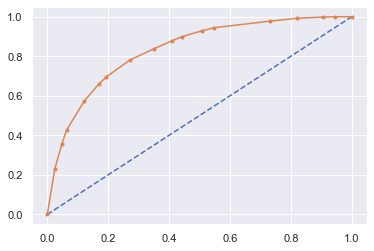

In [187]:
# predict probabilities
probs_dt = best_grid_dtcl.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs_dt = probs_dt[:, 1]
# calculate AUC
auc_dt_train = roc_auc_score(Y_train, probs_dt)
print('AUC Training Data for Decision Tree: %.3f' % auc_dt_train)
# calculate ROC
fpr_dt_train, tpr_dt_train, thresholds_dt_train = roc_curve(Y_train, probs_dt)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dt_train, tpr_dt_train, marker='.')
# show the plot
plt.show()

#### ROC & AUC (Test Data)

AUC Test Data for Decision Tree: 0.798


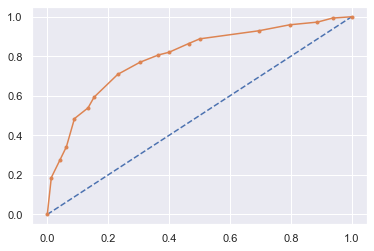

In [188]:
# predict probabilities
probs_dt = best_grid_dtcl.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_dt = probs_dt[:, 1]
# calculate AUC
auc_dt_test = roc_auc_score(Y_test, probs_dt)
print('AUC Test Data for Decision Tree: %.3f' % auc_dt_test)
# calculate ROC
fpr_dt_test, tpr_dt_test, thresholds_dt_test = roc_curve(Y_test, probs_dt)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dt_test, tpr_dt_test, marker='.')
# show the plot
plt.show()

#### Confusion Matrix & Classifiction Report  (Training Data)

In [189]:
confusion_matrix(Y_train, Y_train_predict_dt)

array([[1293,  178],
       [ 269,  360]], dtype=int64)

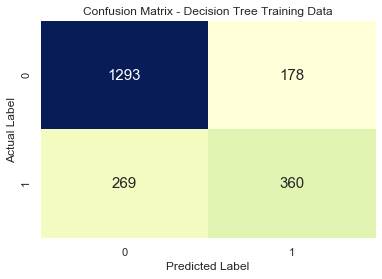

In [190]:
sns.heatmap(confusion_matrix(Y_train,Y_train_predict_dt),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Decision Tree Training Data')
plt.show()

In [191]:
# Decision Tree Training Data Accuracy
dt_train_acc = best_grid_dtcl.score(X_train,Y_train) 
dt_train_acc

0.7871428571428571

In [192]:
print(classification_report(Y_train, Y_train_predict_dt))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1471
           1       0.67      0.57      0.62       629

    accuracy                           0.79      2100
   macro avg       0.75      0.73      0.73      2100
weighted avg       0.78      0.79      0.78      2100



In [193]:
#save the classification report in dataset
dt_cm=classification_report(Y_train, Y_train_predict_dt,output_dict=True)

#transpose the dataset
dt_cm_temp=pd.DataFrame(dt_cm).transpose()

#fetch the key metrics from the table
dt_train_f1=round(dt_cm_temp.loc["0"][2],2)
dt_train_recall=round(dt_cm_temp.loc["0"][1],2)
dt_train_precision=round(dt_cm_temp.loc["0"][0],2)

#### Confusion Matrix & Classifiction Report  (Test Data)

In [194]:
confusion_matrix(Y_test, Y_test_predict_dt)

array([[551,  54],
       [152, 143]], dtype=int64)

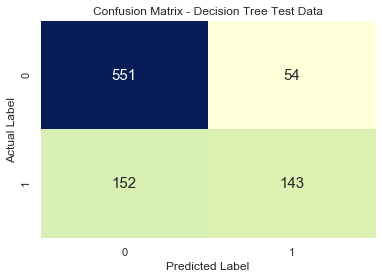

In [195]:
sns.heatmap(confusion_matrix(Y_test, Y_test_predict_dt),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Decision Tree Test Data')
plt.show()

In [196]:
# Decision Tree Test Data Accuracy
dt_test_acc = best_grid_dtcl.score(X_test,Y_test) 
dt_test_acc

0.7711111111111111

In [197]:
print(classification_report(Y_test, Y_test_predict_dt))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       605
           1       0.73      0.48      0.58       295

    accuracy                           0.77       900
   macro avg       0.75      0.70      0.71       900
weighted avg       0.76      0.77      0.76       900



In [198]:
#save the classification report in dataset
dt_cm=classification_report(Y_test, Y_test_predict_dt,output_dict=True)

#transpose the dataset
dt_cm_temp=pd.DataFrame(dt_cm).transpose()

#fetch the key metrics from the table
dt_test_f1=round(dt_cm_temp.loc["0"][2],2)
dt_test_recall=round(dt_cm_temp.loc["0"][1],2)
dt_test_precision=round(dt_cm_temp.loc["0"][0],2)

### Decision Tree Performace Matrix Conclusion:

__Training Data:__ 
   
   - AUC : __83%__
   - Accuracy : __79%__
   - Recall : __88%__
   - Precision : __83%__
   - F1 score : __85%__
        
__Test Data:__ 
   
   - AUC : __80%__
   - Accuracy : __77%__
   - Recall : __91%__
   - Precision : __78%__
   - F1 score : __84%__
             

### ----------------------------------------     Performance Metrics Desicion Tree (DT) Model ENDS   ----------------------------------------

### ----------------------------------------     Performance Metrics Random Forest (RF) Model     ----------------------------------------

#### ROC & AUC (Training Data)

AUC Training Data for Random Forest: 0.863


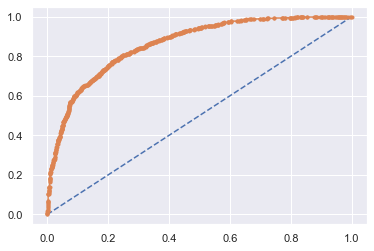

In [199]:
# predict probabilities
probs_rf = best_grid_rfcl.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs_rf = probs_rf[:, 1]
# calculate AUC
auc_rf_train = roc_auc_score(Y_train, probs_rf)
print('AUC Training Data for Random Forest: %.3f' % auc_rf_train)
# calculate ROC
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(Y_train, probs_rf)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rf_train, tpr_rf_train, marker='.')
# show the plot
plt.show()

#### ROC & AUC (Test Data)

AUC Test Data for Random Forest: 0.821


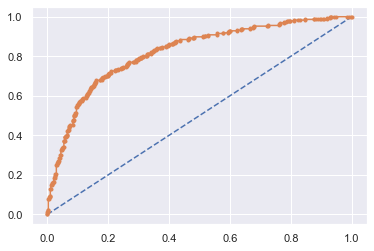

In [200]:
# predict probabilities
probs_rf = best_grid_rfcl.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_rf = probs_rf[:, 1]
# calculate AUC
auc_rf_test = roc_auc_score(Y_test, probs_rf)
print('AUC Test Data for Random Forest: %.3f' % auc_rf_test)
# calculate ROC
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(Y_test, probs_rf)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rf_test, tpr_rf_test, marker='.')
# show the plot
plt.show()

#### Confusion Matrix & Classifiction Report  (Training Data)

In [201]:
confusion_matrix(Y_train, Y_train_predict_rf)

array([[1325,  146],
       [ 241,  388]], dtype=int64)

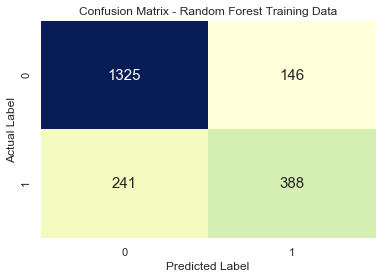

In [202]:
sns.heatmap(confusion_matrix(Y_train, Y_train_predict_rf),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Random Forest Training Data')
plt.show()

In [203]:
# Decision Tree Training Data Accuracy
rf_train_acc = best_grid_rfcl.score(X_train,Y_train) 
rf_train_acc

0.8157142857142857

In [204]:
print(classification_report(Y_train, Y_train_predict_rf))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1471
           1       0.73      0.62      0.67       629

    accuracy                           0.82      2100
   macro avg       0.79      0.76      0.77      2100
weighted avg       0.81      0.82      0.81      2100



In [205]:
#save the classification report in dataset
rf_cm=classification_report(Y_train, Y_train_predict_rf,output_dict=True)

#transpose the dataset
rf_cm_temp=pd.DataFrame(rf_cm).transpose()

#fetch the key metrics from the table
rf_train_f1=round(rf_cm_temp.loc["0"][2],2)
rf_train_recall=round(rf_cm_temp.loc["0"][1],2)
rf_train_precision=round(rf_cm_temp.loc["0"][0],2)

#### Confusion Matrix & Classifiction Report  (Test Data)

In [206]:
confusion_matrix(Y_test, Y_test_predict_rf)

array([[551,  54],
       [148, 147]], dtype=int64)

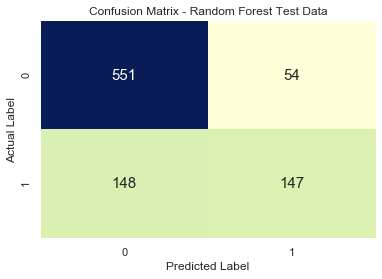

In [207]:
sns.heatmap(confusion_matrix(Y_test, Y_test_predict_rf),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Random Forest Test Data')
plt.show()

In [208]:
# Decision Tree Test Data Accuracy
rf_test_acc = best_grid_rfcl.score(X_test,Y_test) 
rf_test_acc

0.7755555555555556

In [209]:
print(classification_report(Y_test, Y_test_predict_rf))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       605
           1       0.73      0.50      0.59       295

    accuracy                           0.78       900
   macro avg       0.76      0.70      0.72       900
weighted avg       0.77      0.78      0.76       900



In [210]:
#save the classification report in dataset
rf_cm=classification_report(Y_test, Y_test_predict_rf,output_dict=True)

#transpose the dataset
rf_cm_temp=pd.DataFrame(rf_cm).transpose()

#fetch the key metrics from the table
rf_test_f1=round(rf_cm_temp.loc["0"][2],2)
rf_test_recall=round(rf_cm_temp.loc["0"][1],2)
rf_test_precision=round(rf_cm_temp.loc["0"][0],2)

### Random Forest Performace Matrix Conclusion:

__Training Data:__ 
   
   - AUC : __86%__
   - Accuracy : __82%__
   - Recall : __90%__
   - Precision : __85%__
   - F1 score : __87%__
        
__Test Data:__ 
   
   - AUC : __82%__
   - Accuracy : __78%__
   - Recall : __91%__
   - Precision : __79%__
   - F1 score : __85%__
             

### ----------------------------------------     Performance Metrics Random Forest (RF) Model ENDS   ----------------------------------------

### -------------------------------------  Performance Metrics Artificial Neural Network (ANN) Model  ------------------------------------

#### ROC & AUC (Training Data)

AUC Training Data for ANN: 0.848


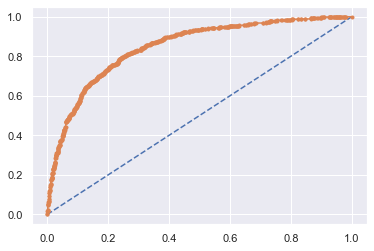

In [211]:
# predict probabilities
probs_nn = best_grid_nncl.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs_nn = probs_nn[:, 1]
# calculate AUC
auc_nn_train = roc_auc_score(Y_train, probs_nn)
print('AUC Training Data for ANN: %.3f' % auc_nn_train)
# calculate ROC
fpr_nn_train, tpr_nn_train, thresholds_nn_train = roc_curve(Y_train, probs_nn)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_nn_train, tpr_nn_train, marker='.')
# show the plot
plt.show()

#### ROC & AUC (Test Data)

AUC Test Data for ANN: 0.812


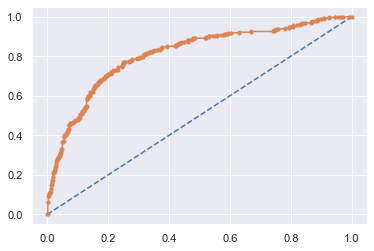

In [212]:
# predict probabilities
probs_nn = best_grid_nncl.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_nn = probs_nn[:, 1]
# calculate AUC
auc_nn_test = roc_auc_score(Y_test, probs_nn)
print('AUC Test Data for ANN: %.3f' % auc_nn_test)
# calculate ROC
fpr_nn_test, tpr_nn_test, thresholds_nn_test = roc_curve(Y_test, probs_nn)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_nn_test, tpr_nn_test, marker='.')
# show the plot
plt.show()

#### Confusion Matrix & Classifiction Report  (Training Data)

In [213]:
confusion_matrix(Y_train, Y_train_predict_nn)

array([[1333,  138],
       [ 290,  339]], dtype=int64)

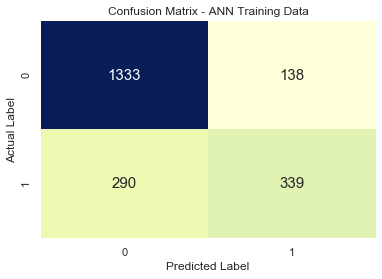

In [214]:
sns.heatmap(confusion_matrix(Y_train, Y_train_predict_nn),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - ANN Training Data')
plt.show()

In [215]:
# Decision Tree Training Data Accuracy
nn_train_acc = best_grid_nncl.score(X_train,Y_train) 
nn_train_acc

0.7961904761904762

In [216]:
print(classification_report(Y_train, Y_train_predict_nn))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1471
           1       0.71      0.54      0.61       629

    accuracy                           0.80      2100
   macro avg       0.77      0.72      0.74      2100
weighted avg       0.79      0.80      0.79      2100



In [217]:
#save the classification report in dataset
nn_cm=classification_report(Y_train, Y_train_predict_nn,output_dict=True)

#transpose the dataset
nn_cm_temp=pd.DataFrame(nn_cm).transpose()

#fetch the key metrics from the table
nn_train_f1=round(nn_cm_temp.loc["0"][2],2)
nn_train_recall=round(nn_cm_temp.loc["0"][1],2)
nn_train_precision=round(nn_cm_temp.loc["0"][0],2)

#### Confusion Matrix & Classifiction Report  (Test Data)

In [218]:
confusion_matrix(Y_test, Y_test_predict_nn)

array([[557,  48],
       [158, 137]], dtype=int64)

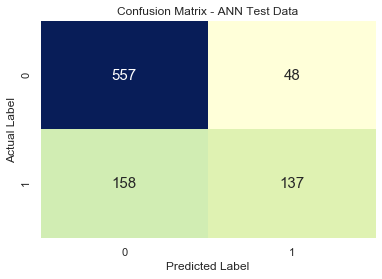

In [219]:
sns.heatmap(confusion_matrix(Y_test, Y_test_predict_nn),annot=True, fmt='d', cbar=False,cmap='YlGnBu',annot_kws={"size": 15})
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - ANN Test Data')
plt.show()

In [220]:
# Decision Tree Test Data Accuracy
nn_test_acc = best_grid_nncl.score(X_test,Y_test) 
nn_test_acc

0.7711111111111111

In [221]:
print(classification_report(Y_test, Y_test_predict_nn))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       605
           1       0.74      0.46      0.57       295

    accuracy                           0.77       900
   macro avg       0.76      0.69      0.71       900
weighted avg       0.77      0.77      0.75       900



In [222]:
#save the classification report in dataset
nn_cm=classification_report(Y_test, Y_test_predict_nn,output_dict=True)

#transpose the dataset
nn_cm_temp=pd.DataFrame(nn_cm).transpose()

#fetch the key metrics from the table
nn_test_f1=round(nn_cm_temp.loc["0"][2],2)
nn_test_recall=round(nn_cm_temp.loc["0"][1],2)
nn_test_precision=round(nn_cm_temp.loc["0"][0],2)

### ANN Performace Matrix Conclusion:

__Training Data:__ 
   
   - AUC : __85%__
   - Accuracy : __80%__
   - Recall : __91%__
   - Precision : __82%__
   - F1 score : __86%__
        
__Test Data:__ 
   
   - AUC : __81%__
   - Accuracy : __77%__
   - Recall : __92%__
   - Precision : __78%__
   - F1 score : __84%__
             

### ---------------------------------  Performance Metrics Artificial Neural Network (ANN) Model  ENDS -------------------------------

## (Question 4) 
## Final Model: Compare all the model and write an inference which model is best/optimized

#### Based on above working let's compare 3 models. For that let's combine all key performance metrics into one dataframe and do the inferences.

In [223]:
comparison = pd.DataFrame({'DT Train' : [auc_dt_train,dt_train_acc,dt_train_recall,dt_train_precision,dt_train_f1],
                           'DT Test' : [auc_dt_test,dt_test_acc,dt_test_recall,dt_test_precision,dt_test_f1],
                           'RF Train': [auc_rf_train,rf_train_acc,rf_train_recall,rf_train_precision,rf_train_f1],
                           'RF Test' : [auc_rf_test,rf_test_acc,rf_test_recall,rf_test_precision,rf_test_f1],
                           'ANN Train': [auc_nn_train,nn_train_acc,nn_train_recall,nn_train_precision,nn_train_f1],
                           'ANN Test' : [auc_nn_test,nn_test_acc,nn_test_recall,nn_test_precision,nn_test_f1]},
                          index = ['AUC', 'Accuracy', 'Recall','Precision','F1 Score'])
comparison.round(2)

,DT Train,DT Test,RF Train,RF Test,ANN Train,ANN Test
AUC,0.83,0.80,0.86,0.82,0.85,0.81
Accuracy,0.79,0.77,0.82,0.78,0.80,0.77
Recall,0.88,0.91,0.90,0.91,0.91,0.92
Precision,0.83,0.78,0.85,0.79,0.82,0.78
F1 Score,0.85,0.84,0.87,0.85,0.86,0.84


## ROC & AUC: Comparision of 3 models

AUC Training Data for DT: 0.833
AUC Training Data for RF: 0.863
AUC Training Data for ANN: 0.848


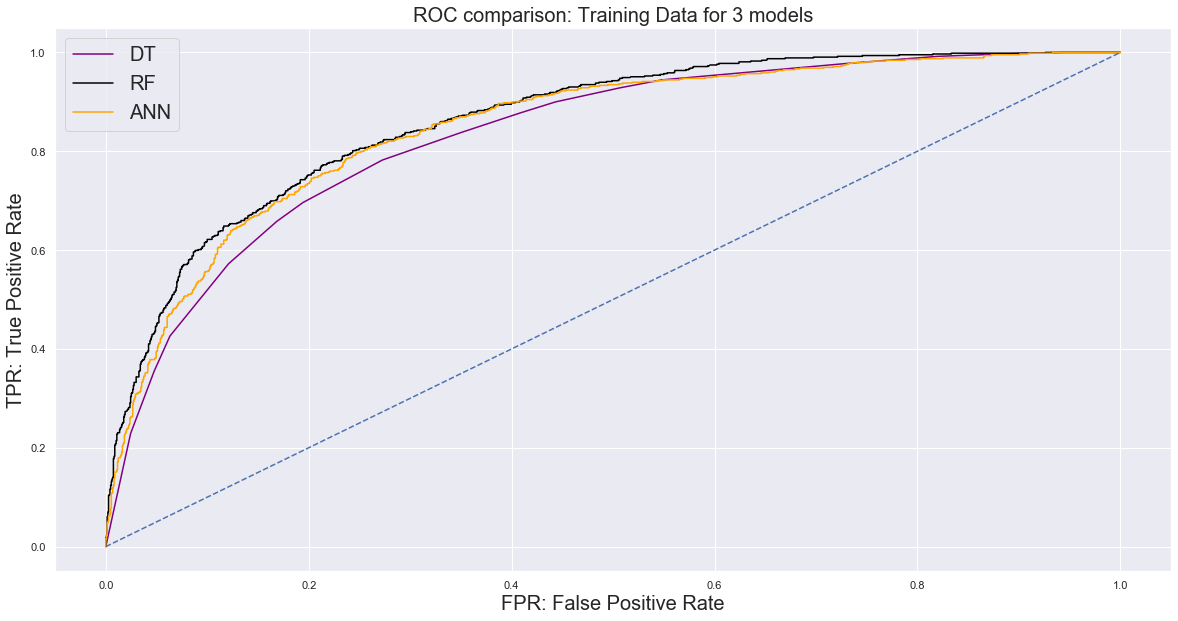

In [224]:
#print AUC values of 3 models : Training Data
print('AUC Training Data for DT: %.3f' % auc_dt_train)
print('AUC Training Data for RF: %.3f' % auc_rf_train)
print('AUC Training Data for ANN: %.3f' % auc_nn_train)

plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_dt_train, tpr_dt_train,color='purple',label="DT")
plt.plot(fpr_rf_train, tpr_rf_train,color='black',label="RF")
plt.plot(fpr_nn_train, tpr_nn_train,color='orange',label="ANN")
plt.xlabel('FPR: False Positive Rate',fontsize=20)
plt.ylabel('TPR: True Positive Rate',fontsize=20)
plt.title("ROC comparison: Training Data for 3 models",fontsize=20)
plt.legend(loc='top left',fontsize=20)
# show the plot
plt.show()

AUC Test Data for DT: 0.798
AUC Test Data for RF: 0.821
AUC Test Data for ANN: 0.812


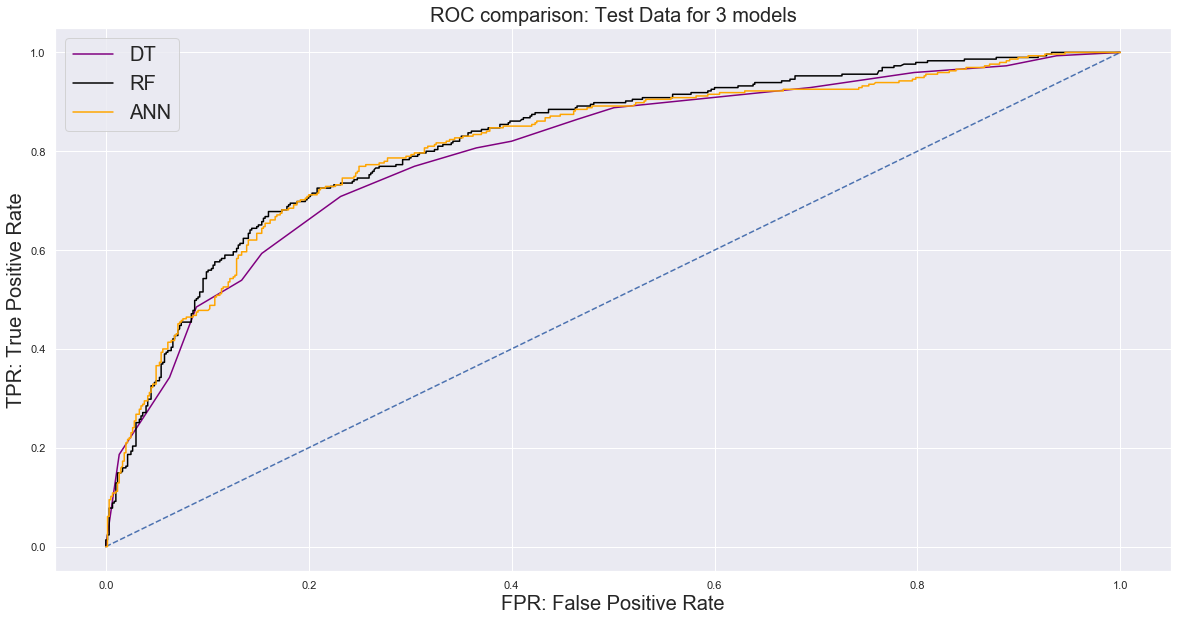

In [225]:
#print AUC values of 3 models : Test Data
print('AUC Test Data for DT: %.3f' % auc_dt_test)
print('AUC Test Data for RF: %.3f' % auc_rf_test)
print('AUC Test Data for ANN: %.3f' % auc_nn_test)


plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_dt_test, tpr_dt_test,color='purple',label="DT")
plt.plot(fpr_rf_test, tpr_rf_test,color='black',label="RF")
plt.plot(fpr_nn_test, tpr_nn_test,color='orange',label="ANN")
plt.xlabel('FPR: False Positive Rate',fontsize=20)
plt.ylabel('TPR: True Positive Rate',fontsize=20)
plt.title("ROC comparison: Test Data for 3 models",fontsize=20)
plt.legend(loc='top left',fontsize=20)
# show the plot
plt.show()